# Voronoi Diagrams Project

### Konfiguracja

In [2]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


##### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [3]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

# Main

### Imports and Global variables

In [4]:
FILE_PATH = './example_sets/'

### Input and save to file

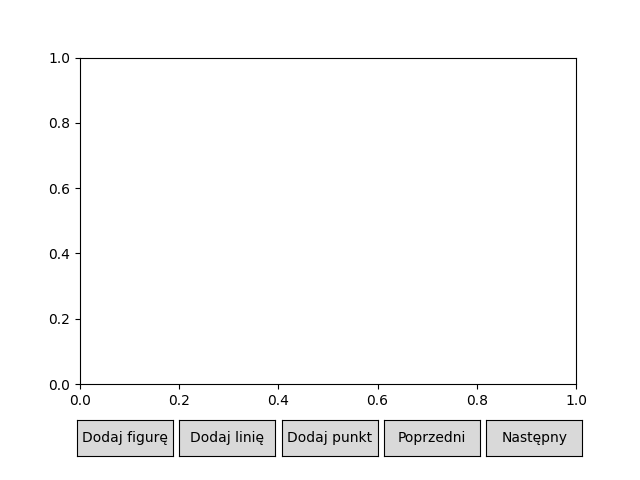

In [5]:
%matplotlib widget

# Draw  points using the mouse and save them as FILE_NAME in FILE_PATH folder

plot_get = Plot(scenes=[Scene()])
plot_get.draw()

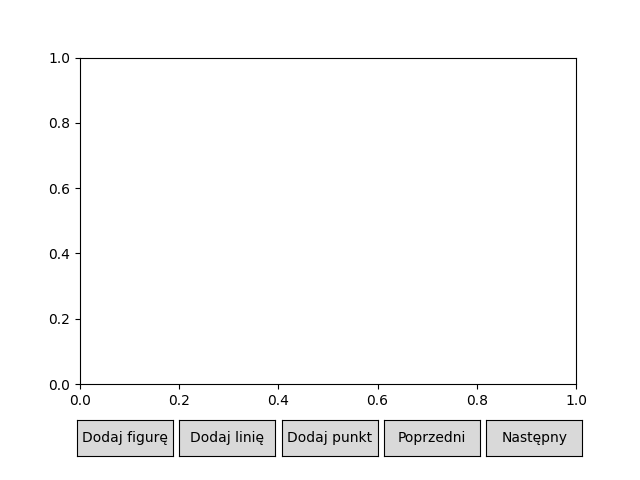

In [6]:
file_name = 'test_simple'
plot_save = Plot([plot_get.get_added_elements()])

with open(FILE_PATH + file_name + '.json', "w") as file:
    file.write(plot_save.toJson())

plot_save.draw()

### Generate random points

In [4]:
def generate_points(amount, left , right):
    array=[None]*amount
    for i in range(amount):
        array[i]=[np.random.uniform(left, right),np.random.uniform(left, right)]
    return array

### Utility Functions and classes

In [5]:
import heapq
import itertools

class Point:
   x = 0.0
   y = 0.0
   
   def __init__(self, x, y):
       self.x = x
       self.y = y

class Event:
    x = 0.0
    p = None
    a = None
    valid = True
    
    def __init__(self, x, p, a):
        self.x = x
        self.p = p
        self.a = a
        self.valid = True

class Arc:
    p = None
    pprev = None
    pnext = None
    e = None
    s0 = None
    s1 = None
    
    def __init__(self, p, a=None, b=None):
        self.p = p
        self.pprev = a
        self.pnext = b 
        self.e = None
        self.s0 = None
        self.s1 = None

class Segment:
    start = None
    end = None
    done = False
    
    def __init__(self, p):
        self.start = p
        self.end = None
        self.done = False

    def finish(self, p):
        if self.done: return
        self.end = p
        self.done = True        

class PriorityQueue:
    def __init__(self):
        self.pq = []
        self.entry_finder = {}
        self.counter = itertools.count()

    def push(self, item):
        # check for duplicate
        if item in self.entry_finder: return
        count = next(self.counter)
        # use x-coordinate as a primary key
        entry = [item.x, count, item]
        self.entry_finder[item] = entry
        heapq.heappush(self.pq, entry)

    def remove_entry(self, item):
        entry = self.entry_finder.pop(item)
        entry[-1] = 'Removed'

    def pop(self):
        while self.pq:
            priority, count, item = heapq.heappop(self.pq)
            if item != 'Removed':
                del self.entry_finder[item]
                return item
        raise KeyError('pop from an empty priority queue')

    def top(self):
        while self.pq:
            priority, count, item = heapq.heappop(self.pq)
            if item != 'Removed':
                del self.entry_finder[item]
                self.push(item)
                return item
        raise KeyError('top from an empty priority queue')

    def empty(self):
        return not self.pq

In [6]:
e = 10**(-12)

In [7]:
def det_3by3(a, b, c):
    '''calculate where point c is located in accordance to vector a-b
    if det > 0, point is on the left
    if < 0 then point on the right
    if 0 then colineal'''


    return a[0]*b[1]+a[1]*c[0]+b[0]*c[1]-c[0]*b[1]-a[1]*b[0]-a[0]*c[1]

In [8]:
def orient(a, b, c):
    '''Orient returns 1 if point c is on the left of the lina a->b, 
    -1 if c is on the right 
    and 0 if the're collineal '''
    d = det_3by3(a, b, c)
    if d > e:
        return 1
    elif d < (-1)*e:
        return -1
    else:
        return 0

In [9]:
def orient_points(a: Point, b: Point, c: Point):
    '''Same as regular orient but works with Point class. 
    Orient returns 1 if point c is on the left of the lina a->b, 
    -1 if c is on the right 
    and 0 if the're collineal '''


    d = det_3by3((a.x, a.y), (b.x, b.y), (c.x, c.y))
    if d > e:
        return 1
    elif d < (-1)*e:
        return -1
    else:
        return 0

In [10]:
def load_points_from_file(FILE_NAME):
    with open(FILE_PATH + FILE_NAME, 'r') as file:
        json = file.read()

    plot = Plot(json=json)

    plot_points = plot.scenes[0].points[0].points

    return plot_points

# Brute force

In [11]:

def find_low_left(points):

    minx , miny = float("inf") , float("inf")
    
    for point in points:

        if point[0] < minx:
            minx = point[0]
        
        if point[1] < miny:
            miny = point[1]

    return (minx,miny)

def find_up_right(points):

    maxx , maxy = float("-inf") , float("-inf")
    
    for point in points:

        if point[0] > maxx:
            maxnx = point[0]
        
        if point[1] > maxy:
            maxy = point[1]
    return (maxx , maxy)


class Brute:
    def __init__(self , points):

        self.points = points
        self.low_left = find_low_left(self.points)
        self.up_right = find_up_right(self.points)

    def find_bisect_line(self,point_a, point_b):
        '''return the a and b value of equasion y = ax + b that is a bisect line of two given points'''
        mid_point = (point_a[0] + point_b[0])/2, (point_a[1] + point_b[1])/2

        a_1 = (point_b[1] - point_a[1])/(point_b[0] - point_a[0])
        b_1 = point_a[1] - a_1*point_a[0]

        a_2 = -1/a_1
        b_2 = mid_point[1] - a_2*mid_point[0]

        # make sure that the current point is on the loeft of the bisect line's vector
        if orient(self.low_left[0], a_2 * self.low_left[0] + b_2, point_a) > 0:
            p1 = (self.low_left[0] , a_2 * self.low_left[0] + b_2)
            p2 = (self.up_right[0] , a_2 * self.up_right[0] + b_2)
        else:
            p2 = (self.low_left[0] , a_2 * self.low_left[0] + b_2)
            p1 = (self.up_right[0] , a_2 * self.up_right[0] + b_2)   

        return (p1,p2)
    
    def voronoi_brute(self):
        
        output = set()

        self.current_point = None
        self.points = self.points.sort(key = lambda x: x[0])

        ''' for i in range(n):
                for j in range(i + 1, n):'''

        for current in self.points:

            bisectors = []
            self.current_point = current

            for point in self.points:

                if point == current:
                    continue

                line = self.find_bisect_line(current , point)
                bisectors.append(line)

            area = self.intersect_half_planes(bisectors)
            self.add_to_output(output , area)

        return output
    
    def intersect_half_planes(self , H):
        if len(H) == 1:
            return H # ((x, y), (u, v))
        else:
            h1 , h2 = self.split_sets(H)
            c1 = self.intersect_half_planes(h1)
            c2 = self.intersect_half_planes(h2)
            C = self.intersect_convex_regions(c1,c2)
        return C
    
    def split_sets(self,H):

        n = len(H)
        h1 = []
        h2 = []

        for i in range(n//2):
            h1.append[H[i]]
        for i in range(n//2,n):
            h2.append(H[i])
        
        return h1 , h2
   

    def add_to_output(output , area):

        for line in area:
            if line not in output:
                output.add(line)
    
    def intersect_convex_regions(self,c1,c2):
        right_edge_c1 = None
        right_edge_c2 = None
        left_edge_c1 = None
        left_edge_c2 = None

        x0 = self.low_left[0]
        x1 = self.up_right[0]

        polygon_1 = self.c_to_polygon(c1)
        polygon_2 = self.c_to_polygon(c2)

        left_1, right_1 = self.make_left_right_chains(polygon_1)
        left_2, right_2 = self.make_left_right_chains(polygon_2)

        if len(polygon_1) <= 2:
            if left_1:
                left_edge_c1 = polygon_1[0], polygon_1[1]
            else:
                right_edge_c1 = polygon_1[0], polygon_1[1]

        if len(polygon_2) <= 2:
            if left_2:
                left_edge_c2 = polygon_2[0], polygon_2[1]
            else:
                right_edge_c2 - polygon_2[0], polygon_2[1]

        left_1_idx = None
        left_2_idx = None
        right_1_idx = None
        right_2_idx = None
        if left_1:
            left_1_idx = 0
            left_edge_c1 = left_1[left_1_idx]
        if right_1:
            right_1_idx = 0
            right_edge_c1 = right_1[right_1_idx]
        if left_2:
            left_2_idx = 0
            left_edge_c2 = left_2[left_2_idx]
        if right_2:
            right_2_idx = 0
            right_edge_c2 = right_2[right_2_idx]

        event = None

        if polygon_1[0][1] > polygon_2[0][1]:
            event = polygon_2[0]
        else:
            event = polygon_1[0]

        result = []

        while event != None:
            if self.is_inside_intersection(event, left_edge_c1, left_edge_c2, right_edge_c1, right_edge_c2):
                result.append[event]

            self.update_idx(left_1, left_1_idx, left_2, left_2_idx, right_1, right_1_idx, right_2, right_2_idx)
            
            if left_1_idx != None:
                left_edge_c1 = left_1[left_1_idx]
            if left_2_idx != None:
                left_edge_c2 = left_2[left_2_idx]
            if right_1_idx != None:
                right_edge_c1 = right_1[right_1_idx]
            if right_2_idx != None:
                right_edge_c2 = right_2[right_2]




    def is_inside_intersection(self, event, left_1, left_2, right_1, right_2):
        pass

    def update_idx(self, left_1, left_1_idx, left_2, left_2_idx, right_1, right_1_idx, right_2, right_2_idx):
        '''find the next event and upadte the indexes of lines'''
        pass


    def c_to_polygon(self, c):
        '''creates and returns a polygon (list of vertecies) from a list of lines'''
        polygon = []

        for line in c:
            polygon.append(line[0])

        if c[len(c) - 1][1] not in polygon:
            polygon.append(c[len(c) - 1][1])

        return polygon

    def make_left_right_chains(self, polygon):
        n = len(polygon)
        max_y = -float('inf')
        min_y = float('inf')
        for i, point in enumerate(polygon):
            if point[1] > max_y:
                max_y = point[1]
                max_i = i
            if point[1] < min_y:
                min_y = point[1]
                min_i = i

        left = []
        right = []

        left_i = max_i + 1
        right_i = max_i - 1


        while left_i != min_i:
            if left_i > n:
                left_i = 0
            left.append(polygon[left_i])
            left_i += 1

        while right_i != min_i:
            if right_i < 0:
                right_i = n
            right.append(polygon[right_i])
            right_i -= 1


        return left, right

# Fortune's Algorithm

In [12]:
from copy import copy

In [13]:
##### TEST KODU v1

import random
import math
import numpy as np

class Voronoi:
    def __init__(self, points):
        self.points_copy = points
        self.output = [] # list of line segment
        self.arc = None  # binary tree for parabola arcs

        self.points = PriorityQueue() # site events
        self.event = PriorityQueue() # circle events

        self.scenes = [] # empty scene list

        # bounding box
        box = self.bounding_box(self.points_copy)
        self.x0 = box[0][0]
        self.x1 = box[1][0]
        self.y0 = box[0][1]
        self.y1 = box[1][1]

        # insert points to site event
        for p in points:
            point = Point(p[0], p[1])
            self.points.push(point)

    def create_diagram(self):
        while not self.points.empty():
            if not self.event.empty() and (self.event.top().x <= self.points.top().x):
                self.process_event() # handle circle event
            else:
                self.process_point() # handle site event

        # after all points, process remaining circle events
        while not self.event.empty():
            self.process_event()

        # complete any unfinished segments
        self.finish_edges()


    def process_point(self):
        p = self.points.pop()

        self.add_scene(p)

        self.arc_insert(p)

    def process_event(self):
        e = self.event.pop()



        if e.valid:
            self.add_scene(e)
            # start new edge
            s = Segment(e.p)
            self.output.append(s)

            # remove associated arc (parabola)
            a = e.a
            if a.pprev is not None:
                a.pprev.pnext = a.pnext
                a.pprev.s1 = s
            if a.pnext is not None:
                a.pnext.pprev = a.pprev
                a.pnext.s0 = s

            # finish the edges before and after a
            if a.s0 is not None: 
                a.s0.finish(e.p)
            if a.s1 is not None: 
                a.s1.finish(e.p)

            # recheck circle events on either side of p
            if a.pprev is not None: 
                self.check_circle_event(a.pprev, e.x)
            if a.pnext is not None: 
                self.check_circle_event(a.pnext, e.x)

    def arc_insert(self, p):
        if self.arc is None:
            self.arc = Arc(p)
        else:
            # find the current arcs at p.y
            i = self.arc
            while i is not None:
                flag, z = self.intersect(p, i)
                if flag:
                    # new parabola intersects arc i
                    flag, zz = self.intersect(p, i.pnext)
                    if (i.pnext is not None) and (not flag):
                        i.pnext.pprev = Arc(i.p, i, i.pnext)
                        i.pnext = i.pnext.pprev
                    else:
                        i.pnext = Arc(i.p, i)
                    i.pnext.s1 = i.s1

                    # add p between i and i.pnext
                    i.pnext.pprev = Arc(p, i, i.pnext)
                    i.pnext = i.pnext.pprev

                    i = i.pnext # now i points to the new arc

                    # add new half-edges connected to i's endpoints
                    seg = Segment(z)
                    self.output.append(seg)
                    i.pprev.s1 = i.s0 = seg

                    seg = Segment(z)
                    self.output.append(seg)
                    i.pnext.s0 = i.s1 = seg

                    # check for new circle events around the new arc
                    self.check_circle_event(i, p.x)
                    self.check_circle_event(i.pprev, p.x)
                    self.check_circle_event(i.pnext, p.x)

                    return
                        
                i = i.pnext

            # if p never intersects an arc, append it to the list
            i = self.arc
            while i.pnext is not None:
                i = i.pnext
            i.pnext = Arc(p, i)
            
            # insert new segment between p and i
            x = self.x0
            y = (i.pnext.p.y + i.p.y) / 2.0
            start = Point(x, y)

            seg = Segment(start)
            i.s1 = i.pnext.s0 = seg
            self.output.append(seg)

    def check_circle_event(self, i, x0):
        # look for a new circle event for arc i
        if (i.e is not None) and (i.e.x  != self.x0):
            i.e.valid = False
        i.e = None

        if (i.pprev is None) or (i.pnext is None): return

        flag, x, o = self.circle(i.pprev.p, i.p, i.pnext.p)
        if flag and (x > self.x0):
            i.e = Event(x, o, i)
            self.event.push(i.e)

    def circle(self, a, b, c):
        # check if bc is a "right turn" from ab
        if orient_points(a, b, c) > 0: return False, None, None

        if orient_points(a, b, c) == 0: return False, None, None # Points are co-linear

        A = b.x - a.x
        B = b.y - a.y
        C = c.x - a.x
        D = c.y - a.y
        E = A*(a.x + b.x) + B*(a.y + b.y)
        F = C*(a.x + c.x) + D*(a.y + c.y)
        G = 2*(A*(c.y - b.y) - B*(c.x - b.x))

        # calculate the center of the circle
        ox = 1.0 * (D*E - B*F) / G
        oy = 1.0 * (A*F - C*E) / G

        # o.x plus radius equals max x coord
        x = ox + math.sqrt((a.x-ox)**2 + (a.y-oy)**2)
        o = Point(ox, oy)
           
        return True, x, o
        
    def intersect(self, p, i):
        # check whether a new parabola at point p intersect with arc i
        if (i is None): return False, None
        if (i.p.x == p.x): return False, None

        a = 0.0
        b = 0.0

        if i.pprev is not None:
            a = (self.intersection(i.pprev.p, i.p, p.x)).y
        if i.pnext is not None:
            b = (self.intersection(i.p, i.pnext.p, p.x)).y

        if (((i.pprev is None) or (a <= p.y)) and ((i.pnext is None) or (p.y <= b))):
            py = p.y
            px = 1.0 * ((i.p.x)**2 + (i.p.y-py)**2 - p.x**2) / (2*i.p.x - 2*p.x)
            res = Point(px, py)
            return True, res
        return False, None

    def intersection(self, p0, p1, l):
        # get the intersection of two parabolas
        p = p0
        if (p0.x == p1.x):
            py = (p0.y + p1.y) / 2.0
        elif (p1.x == l):
            py = p1.y
        elif (p0.x == l):
            py = p0.y
            p = p1
        else:
            # use quadratic formula
            z0 = 2.0 * (p0.x - l)
            z1 = 2.0 * (p1.x - l)

            a = 1.0/z0 - 1.0/z1
            b = -2.0 * (p0.y/z0 - p1.y/z1)
            c = 1.0 * (p0.y**2 + p0.x**2 - l**2) / z0 - 1.0 * (p1.y**2 + p1.x**2 - l**2) / z1

            py = 1.0 * (-b-math.sqrt(b*b - 4*a*c)) / (2*a)
            
        px = 1.0 * (p.x**2 + (p.y-py)**2 - l**2) / (2*p.x-2*l)
        res = Point(px, py)
        return res

    def finish_edges(self):
        l = self.x1 + (self.x1 - self.x0) + (self.y1 - self.y0)
        i = self.arc
        while i.pnext is not None:
            if i.s1 is not None:
                p = self.intersection(i.p, i.pnext.p, 2*l)
                p = self.is_p_in_bound(p, i.s1)
                i.s1.finish(p)
                self.add_scene(Point(self.x1, self.y1))
            i = i.pnext

    def is_p_in_bound(self, p: Point, line: Segment):
        if line.start.x > self.x1 or line.start.x < self.x0:
            if line.start.y > self.y1 or line.start.y < self.y0:
                return line.start

        point_b = p.x, p.y
        point_a = line.start.x, line.start.y
        new_x = p.x
        new_y = p.y

        a_1 = (point_b[1] - point_a[1])/(point_b[0] - point_a[0])
        b_1 = point_a[1] - a_1*point_a[0]

        if self.x0 <= p.x <= self.x1:
            new_x = p.x
        else:
            if p.x < self.x0:
                new_x = self.x0
            if p.x > self.x1:
                new_x = self.x1

        if self.y0 <= p.y <= self.y1:
            new_y = a_1*new_x + b_1
        else:
            if p.y < self.y0:
                new_y = self.y0
                new_x = (new_y - b_1) / a_1
            if p.y > self.y1:
                new_y = self.y1
                new_x = (new_y - b_1) / a_1


        return Point(new_x, new_y)


            
    def add_scene(self, event):
        p, l = self.get_current_scene()
        self.scenes.append(Scene(points=[PointsCollection(self.points_copy), PointsCollection(p, color = "red")],
        lines=[LinesCollection(l, color = "green"), LinesCollection([[(event.x, self.y0), (event.x, self.y1)]], color = "red")]))

    def get_current_scene(self):
        points = []
        lines = []
        for item in self.output:
            if item.done:
                line = ((item.start.x, item.start.y), (item.end.x, item.end.y))
                lines.append(line)
            else:
                point = (item.start.x, item.start.y)
                points.append(point)

        return points, lines
        

    def point_list(self):
        res = []
        for o in self.output:
            p_0 = o.start
            res.append((p_0.x, p_0.y))

        return res
    def segment_to_list(self):
        result = []
        for o in self.output:
            p0 = o.start
            p1 = o.end
            result.append(((p0.x, p0.y), (p1.x, p1.y)))

    def print_output(self):
        it = 0
        for o in self.output:
            it = it + 1
            p0 = o.start
            p1 = o.end
            print (p0.x, p0.y, p1.x, p1.y)

    def get_output(self):
        res = []
        for o in self.output:
            p0 = o.start
            p1 = o.end
            res.append(((p0.x, p0.y), (p1.x, p1.y)))
            
        ret = LinesCollection(lines=res)    
        return ret

    def bounding_box(self, points):
        '''returns a tuple conataining a pair of vectors, lower left edge of point set an upper right with added 20% margins'''
        min_x = float('inf')
        min_y = float('inf')
        max_x = -float('inf')
        max_y = -float('inf')

        n = len(points)

        for i in range(n):
            if points[i][0] < min_x:
                min_x = points[i][0]

            if points[i][1] < min_y:
                min_y = points[i][1]

            if points[i][0] > max_x:
                max_x = points[i][0]

            if points[i][1] > max_y:
                max_y = points[i][1]

        width = max_x - min_x
        height = max_y - min_y

        result = (min_x - 0.5*width, min_y - 0.5*height), (max_x + 0.5*width, max_y + 0.5*height)

        return result

In [14]:
a = generate_points(20, -10, 10)

In [15]:
CURRENT_TEST = 'test_2.json'

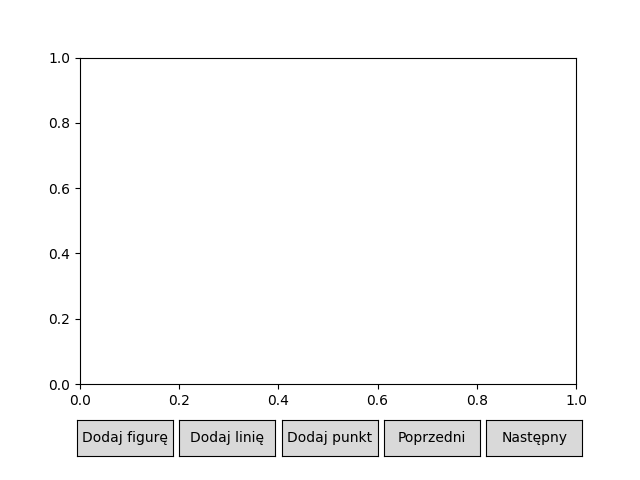

In [17]:
%matplotlib widget
points = load_points_from_file(CURRENT_TEST)
vor = Voronoi(points)
vor.create_diagram()
# print(result)
# plot = Plot(points=[PointsCollection(a)], lines=[LinesCollection(result)])
# plot.draw()
plot = Plot(scenes=vor.scenes)
plot.draw()